In [1]:
from models import *
from train import *
from plot import *
from utils import *
from explore import *
import matplotlib.pyplot as plt


# Manual model testing

In [2]:
# Import dataset
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

In [3]:
model_builder = Siamese
model_params = {
    'fc_parameters': {'input_size': 64}
}
model = model_builder(**model_params)

In [4]:
model_builder = BaseLineNet
model_params = {}
model = model_builder(**model_params)

In [5]:
show_values = False

_train_input = train_input[0:5]
_train_target = train_target[0:5]
_train_classes = train_classes[0:5]

one_hot_classes = True
one_hot_leq = False
_data_input, _data_target, _data_classes = \
        preprocess_dataset(_train_input, _train_target, _train_classes,
                           one_hot_classes=one_hot_classes, one_hot_leq=one_hot_leq,
                           device=torch.device('cpu'))

print(f'train input: size={_train_input.size()}, dtype={_train_input.dtype}')
print(f'train target: size={_train_target.size()}, dtype={_train_target.dtype}')
print(f'train classes: size={_train_classes.size()}, dtype={_train_classes.dtype}')

print()
print(f'data input: size={_data_input.size()}, dtype={_data_input.dtype}')
print(f'data target: size={_data_target.size()}, dtype={_data_target.dtype}')
print(f'data classes: size={_data_classes.size()}, dtype={_data_classes.dtype}')

with torch.no_grad():
    pred_leq, (pred_class0, pred_class1) = model(_train_input)
    print()
    print(f'Less or equal output: size={pred_leq.size()}, dtype={pred_leq.dtype}')
    if show_values:
        print(pred_leq)
    print(f'Class0 output: size={pred_class0.size()}, dtype={pred_class0.dtype}{pred_class0 if show_values else ""}')
    if show_values:
        print(pred_class0)
    print(f'Class1 output: size={pred_class1.size()}, dtype={pred_class1.dtype}{pred_class1 if show_values else ""}')
    if show_values:
        print(pred_class1)


train input: size=torch.Size([5, 2, 14, 14]), dtype=torch.float32
train target: size=torch.Size([5]), dtype=torch.int64
train classes: size=torch.Size([5, 2]), dtype=torch.int64

data input: size=torch.Size([5, 2, 14, 14]), dtype=torch.float32
data target: size=torch.Size([5, 1]), dtype=torch.float32
data classes: size=torch.Size([5, 2, 10]), dtype=torch.float32

Less or equal output: size=torch.Size([5, 1]), dtype=torch.float32
Class0 output: size=torch.Size([5, 10]), dtype=torch.float32
Class1 output: size=torch.Size([5, 10]), dtype=torch.float32


In [6]:
# Model parameters
summary(model, input_size=(1, 2, 14, 14))

Layer (type:depth-idx)                   Output Shape              Param #
BaseLineNet                              [1, 1]                    --
├─Linear: 1-1                            [1, 150]                  58,950
├─Linear: 1-2                            [1, 80]                   12,080
├─Linear: 1-3                            [1, 20]                   1,620
├─Linear: 1-4                            [1, 1]                    21
Total params: 72,671
Trainable params: 72,671
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.29
Estimated Total Size (MB): 0.29

## Single cycle testing

In [7]:
# device = torch.device('cpu') 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start = time.perf_counter()
info_cycle = train_model(model,
                            train_input, train_target, train_classes,
                            nb_epochs=20, mini_batch_size=100,
                            criterion_classes=nn.CrossEntropyLoss(), criterion_classes_params={'input': 'pred_class{i}', 'target': 'data_classes{i}'},
                            criterion_leq=nn.BCELoss(), criterion_leq_params={'input': 'pred_leq', 'target': 'data_target'},
                            optimizer=torch.optim.SGD(model.parameters(), lr=4e-3),
                            weight_loss_classes=0.0, weight_loss_leq=1.0,
                            freeze_epochs=0,
                            one_hot_classes=True, one_hot_leq=False,
                            verbose=False,
                            test_input=test_input, test_target=test_target, test_classes=test_classes,
                            unsqueeze_leq=True,
                            device=device)
end = time.perf_counter()
print(f'Time: {end - start:.2f}s')

Time: 0.21s


In [8]:
with torch.no_grad():
    # pred_leq, (pred_class0, pred_class1) = model(train_input)
    pred_leq, (pred_class0, pred_class1) = compute_predictions(model, train_input.to(device),
                                                               one_hot_classes=one_hot_classes, one_hot_leq=one_hot_leq)
    
    # print(pred_leq.size(), train_target.size())
    acc_leq = (pred_leq == train_target.unsqueeze(1).to(device)).float().mean().item()
    print(f'Accuracy on the training set: {acc_leq:.4f}')
    print(classification_report(train_classes[:, 0], pred_class0.cpu(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))
    print(classification_report(train_classes[:, 1], pred_class1.cpu(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

Accuracy on the training set: 0.7920
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.36      0.04      0.07        98
           2       0.15      0.63      0.24       113
           3       0.00      0.00      0.00       102
           4       0.22      0.08      0.12        97
           5       0.06      0.02      0.03        84
           6       0.00      0.00      0.00        97
           7       0.09      0.31      0.14       108
           8       0.00      0.00      0.00        97
           9       0.00      0.00      0.00       100

    accuracy                           0.12      1000
   macro avg       0.09      0.11      0.06      1000
weighted avg       0.09      0.12      0.06      1000

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.02      0.07      0.03       109
           2       0.00      0.00      0.

/home/ethan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ethan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ethan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ethan/.local/lib/python3.10/site-p

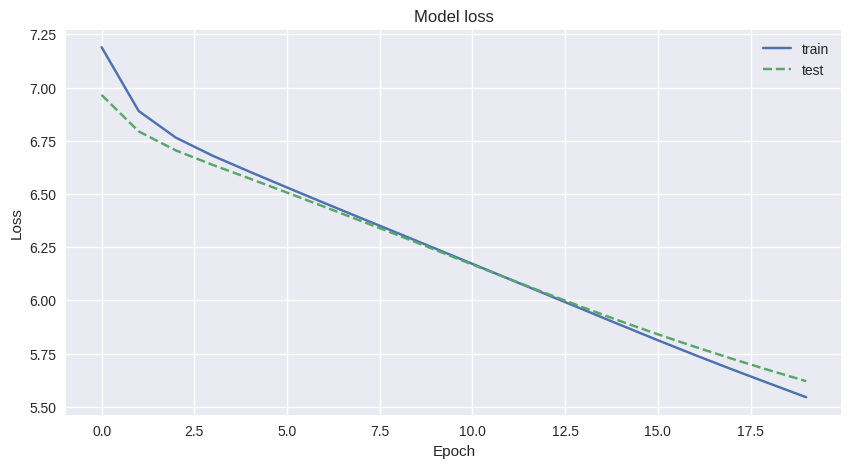

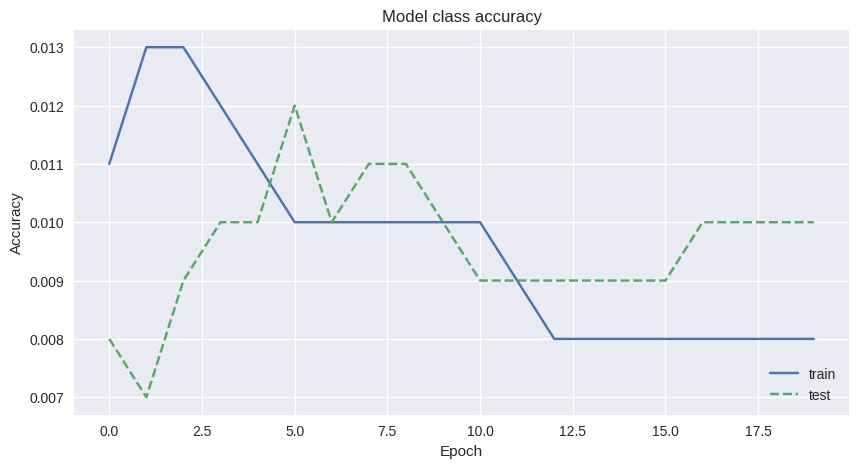

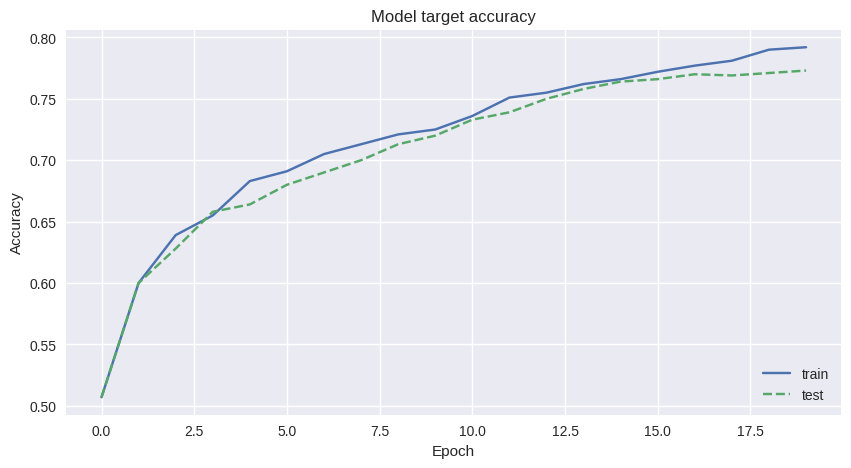

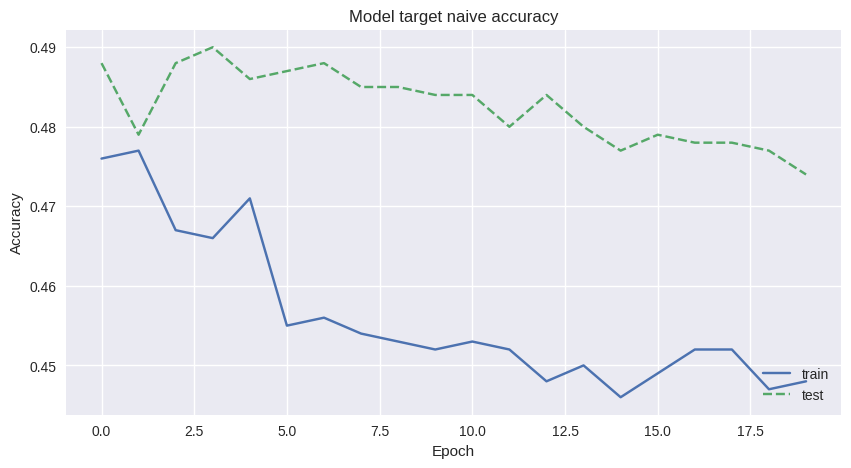

[<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>]

In [9]:
plot_info_cycle(info_cycle)

## Multiple cycle testing

In [10]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = {'model_builder': model_builder, 'model_params': model_params,
          'nb_epochs': 20, 'mini_batch_size': 100,
          'criterion_classes': nn.CrossEntropyLoss(), 'criterion_classes_params': {'input': 'pred_class{i}', 'target': 'data_classes{i}'},
          'criterion_leq': nn.BCELoss(), 'criterion_leq_params': {'input': 'pred_leq', 'target': 'data_target'},
          'optimizer_builder': torch.optim.Adam, 'optimizer_params': {},
          'weight_loss_classes': 0.0, 'weight_loss_leq': 1.0,
          'freeze_epochs': 0,
          'one_hot_classes': True, 'one_hot_leq': False,
          'unsqueeze_leq': True,
          'device': device,
          'n_cycle': 10
          }
          
info = evaluate_model(**params)


Cycle 1/10
Epoch 1/20 - Train loss: 6.7359
Epoch 1/20 - Test loss: 6.2683
Epoch 2/20 - Train loss: 5.8276
Epoch 2/20 - Test loss: 5.6793
Epoch 3/20 - Train loss: 5.3002
Epoch 3/20 - Test loss: 5.4184
Epoch 4/20 - Train loss: 4.9976
Epoch 4/20 - Test loss: 5.2879
Epoch 5/20 - Train loss: 4.7967
Epoch 5/20 - Test loss: 5.4111
Epoch 6/20 - Train loss: 4.4981
Epoch 6/20 - Test loss: 5.2615
Epoch 7/20 - Train loss: 4.0970
Epoch 7/20 - Test loss: 5.0334
Epoch 8/20 - Train loss: 3.6487
Epoch 8/20 - Test loss: 5.2640
Epoch 9/20 - Train loss: 3.3354
Epoch 9/20 - Test loss: 6.0818
Epoch 10/20 - Train loss: 3.4736
Epoch 10/20 - Test loss: 5.2197
Epoch 11/20 - Train loss: 3.6344
Epoch 11/20 - Test loss: 5.0509
Epoch 12/20 - Train loss: 3.0953
Epoch 12/20 - Test loss: 4.9715
Epoch 13/20 - Train loss: 2.7091
Epoch 13/20 - Test loss: 5.1454
Epoch 14/20 - Train loss: 2.2875
Epoch 14/20 - Test loss: 5.1263
Epoch 15/20 - Train loss: 2.0947
Epoch 15/20 - Test loss: 5.0052
Epoch 16/20 - Train loss: 1.9425

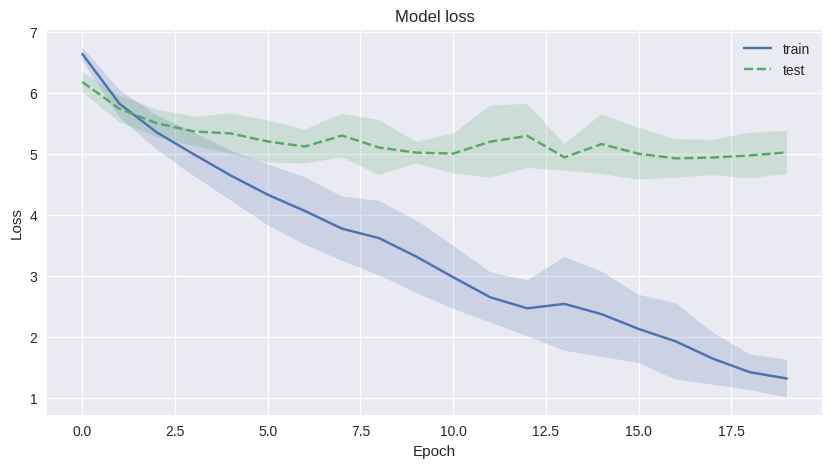

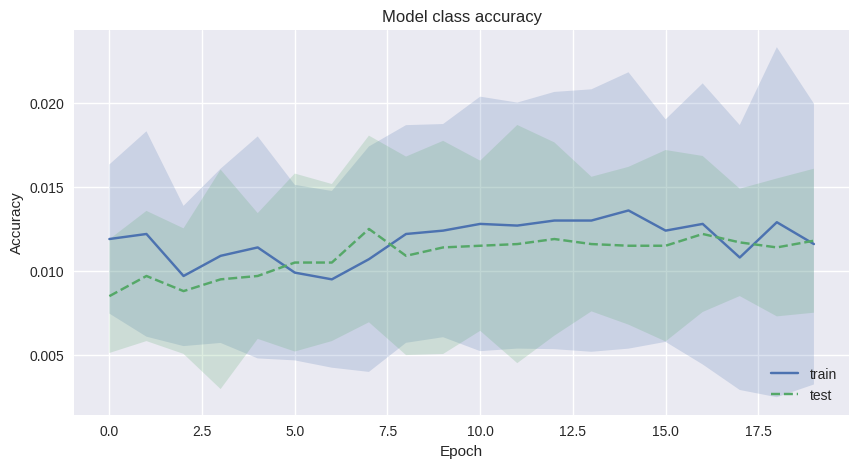

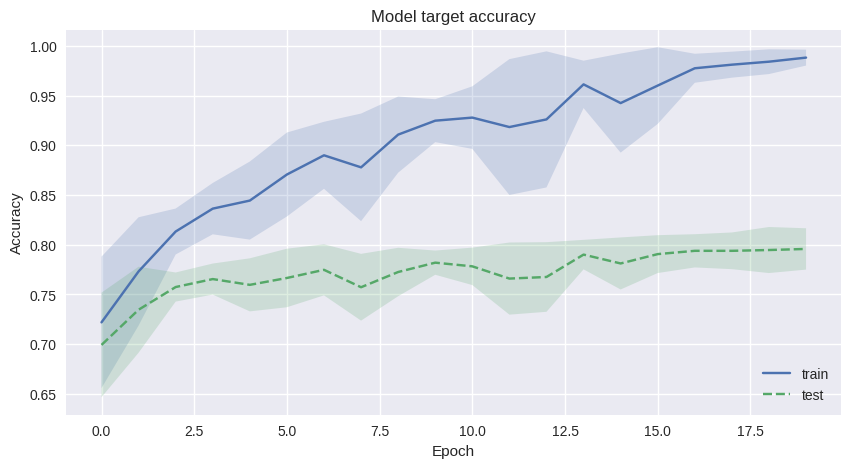

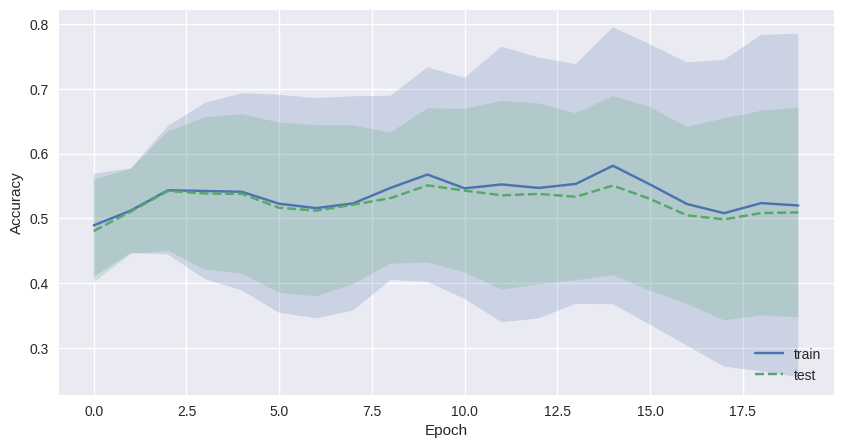

In [11]:
stats = info_stats(info)
plot_stats(stats)

# Automated grid search

In [12]:
while (out := input('Proceed with the automated search? [y/n] ')) != 'y':
    if out == 'n':
        break

## Different model types

In [13]:
MODELS = []

# SIAMESE
conv_block = {
    'dropout1': [0.0],
    'dropout2': [0.0],
    'activation1': [nn.ReLU()],
    'activation2': [nn.ReLU()],
    'use_batch_norm': [True],
    'use_skip_connections': [True],
}
conv_block_parameters_list = parameters_combinations(
    *conv_block.values(), labels=conv_block.keys())
fc_block = {
    'dropout': [0.0],
    'activation1': [nn.ReLU()],
    'activation2': [nn.ReLU()],
    'use_batch_norm': [True]
}
fc_block_parameters_list = parameters_combinations(
    *fc_block.values(), labels=fc_block.keys())
predict_list = [build_predictFC()]

model_params_list = parameters_combinations(conv_block_parameters_list, fc_block_parameters_list, predict_list,
                                            labels=['conv_block_parameters', 'fc_parameters', 'predict'])

model_dict1 = {
    'model_builder': [Siamese],
    'model_params': model_params_list,
    'one_hot_classes': [True],
    'one_hot_leq': [False],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict1))

# BASELINE

model_dict2 = {
    'model_builder': [BaseLineNet],
    'model_params': [{}],
    'one_hot_classes': [True],
    'one_hot_leq': [False],
    'unsqueeze_leq': [True],
}

MODELS.extend(parameters_combinations_from_dict(model_dict2))


In [14]:
nb_epochs_list = [25]
mini_batch_size_list = [100]

default_criterion_classes_params = {'input': 'pred_class{i}', 'target': 'data_classes{i}'}
criterion_classes_tuple = [(nn.CrossEntropyLoss(), default_criterion_classes_params)]
criterion_classes_combination = [dict(zip(['criterion_classes', 'criterion_classes_params'], criterion_classes_tuple)) for criterion_classes_tuple in criterion_classes_tuple]

default_criterion_leq_params = {'input': 'pred_leq', 'target': 'data_target'}
criterion_leq_tuples = [(nn.BCELoss(), default_criterion_leq_params)]
criterion_leq_combination = [dict(zip(['criterion_leq', 'criterion_leq_params'], criterion_leq_tuple)) for criterion_leq_tuple in criterion_leq_tuples]

default_optimizer_params = {}
optimizer_tuples = [(torch.optim.Adam, default_optimizer_params)]
optimizer_combination = [dict(zip(['optimizer_builder', 'optimizer_params'], optimizer_tuple)) for optimizer_tuple in optimizer_tuples]

weight_loss_tuples = [(0.0, 1.0), (1.0, 0.0), (0.5, 0.5)]
weight_loss_combination = [dict(zip(['weight_loss_classes', 'weight_loss_leq'], wl_tuple)) for wl_tuple in weight_loss_tuples]

freeze_epochs_list = [0]

# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_list = [device]

n_cycle_list = [1]

TRAINING = parameters_combinations(
    nb_epochs_list,
    mini_batch_size_list,
    freeze_epochs_list,
    device_list,
    n_cycle_list,
    labels=[
        'nb_epochs',
        'mini_batch_size',
        'freeze_epochs',
        'device',
        'n_cycle'
        ]
)
TRAINING = mix_parameters_combinations(TRAINING, criterion_classes_combination, criterion_leq_combination, optimizer_combination, weight_loss_combination)

In [15]:
FINAL = mix_parameters_combinations(MODELS, TRAINING)
print(len(FINAL))

6


In [16]:
# print(len(MODELS))
# print(len(TRAINING))
# print(len(MODELS) * len(TRAINING))
# print(len(FINAL))
# print(FINAL[0])
# print(TRAINING[0])
# print(MODELS[0])
# print_parameters_combinations(TRAINING)
# print(len(parameters_combinations_from_dict(model_dict1)))
# print(len(parameters_combinations_from_dict(model_dict2)))
# print(len(parameters_combinations_from_dict(model_dict1)
#           + parameters_combinations_from_dict(model_dict2)))
# print(model_params[0])
# print(conv_block_parameters[0])

In [17]:
path = create_folder_with_datetime('Experiments')
for i, params in enumerate(FINAL):
    path_dir = os.path.join(path, params['model_builder'].__name__, str(i))
    os.makedirs(path_dir, exist_ok=True)
    export_parameters(params, os.path.join(path_dir, 'parameters.json'))

    info = evaluate_model(**params)

    stats = info_stats(info)
    export_info(info, os.path.join(path_dir, 'info.json'))
    export_info(stats, os.path.join(path_dir, 'stats.json'))
    plot_stats(stats, **SAVE_ARGS, path=path_dir)

Cycle 1/10


/home/ethan/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/25 - Train loss: 6.5347
Epoch 1/25 - Test loss: 6.2495
Epoch 2/25 - Train loss: 5.8659
Epoch 2/25 - Test loss: 5.9176
Epoch 3/25 - Train loss: 5.4771
Epoch 3/25 - Test loss: 5.6638
Epoch 4/25 - Train loss: 5.0818
Epoch 4/25 - Test loss: 5.4075
Epoch 5/25 - Train loss: 4.6718
Epoch 5/25 - Test loss: 5.1877
Epoch 6/25 - Train loss: 4.2426
Epoch 6/25 - Test loss: 4.9320
Epoch 7/25 - Train loss: 3.7817
Epoch 7/25 - Test loss: 4.7685
Epoch 8/25 - Train loss: 3.2952
Epoch 8/25 - Test loss: 4.6182
Epoch 9/25 - Train loss: 2.7728
Epoch 9/25 - Test loss: 4.5575
Epoch 10/25 - Train loss: 2.2558
Epoch 10/25 - Test loss: 4.5307
Epoch 11/25 - Train loss: 1.7858
Epoch 11/25 - Test loss: 4.7318
Epoch 12/25 - Train loss: 1.4248
Epoch 12/25 - Test loss: 5.0641
Epoch 13/25 - Train loss: 1.1193
Epoch 13/25 - Test loss: 5.3508
Epoch 14/25 - Train loss: 0.9850
Epoch 14/25 - Test loss: 4.8812
Epoch 15/25 - Train loss: 0.8926
Epoch 15/25 - Test loss: 5.0046
Epoch 16/25 - Train loss: 0.7416
Epoch 16/2

In [18]:
# [nn.ReLU, nn.LeakyReLU, nn.Sigmoid, nn.ELU, nn.GELU]